<a href="https://colab.research.google.com/github/RAVIYADAV6522/AlgoJourney/blob/main/SVM_Floor_NonFloor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt


from collections import defaultdict
from skimage.feature import local_binary_pattern


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [34]:
import time

In [35]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
IMAGE_DIR = "/content/drive/MyDrive/RaviYadav_230131"
COCO_JSON = "/content/drive/MyDrive/RaviYadav_annotations.json"

In [37]:
with open(COCO_JSON) as f:
   coco = json.load(f)


image_id_to_filename = {
   img["id"]: img["file_name"] for img in coco["images"]
}


annotations_by_image = defaultdict(list)
for ann in coco["annotations"]:
   annotations_by_image[ann["image_id"]].append(ann)


print("Total images in COCO:", len(coco["images"]))
print("Total annotations:", len(coco["annotations"]))



Total images in COCO: 10
Total annotations: 32


In [38]:
def coco_polygon_to_mask(image_shape, segmentations):
   mask = np.zeros(image_shape[:2], dtype=np.uint8)
   for seg in segmentations:
       pts = np.array(seg).reshape(-1, 2).astype(np.int32)
       cv2.fillPoly(mask, [pts], 1)
   return mask

In [39]:
images, masks = [], []


for img in coco["images"]:
   img_path = os.path.join(IMAGE_DIR, img["file_name"])
   image = cv2.imread(img_path)


   if image is None:
       print("Skipping unreadable image:", img["file_name"])
       continue


   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


   anns = annotations_by_image.get(img["id"], [])
   if len(anns) == 0:
       print("No floor annotation for:", img["file_name"])
       continue


   segmentations = [a["segmentation"][0] for a in anns]
   mask = coco_polygon_to_mask(image.shape, segmentations)


   images.append(image)
   masks.append(mask)


print(f"Loaded {len(images)} valid image-mask pairs")


Loaded 10 valid image-mask pairs


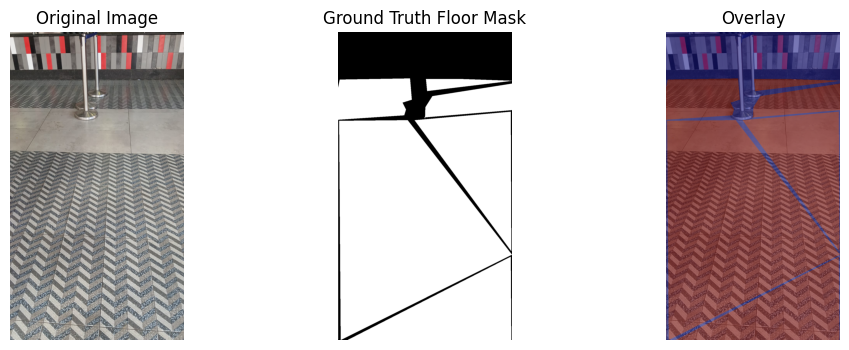

In [40]:
idx = 0


plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(images[idx])
plt.title("Original Image")
plt.axis("off")


plt.subplot(1,3,2)
plt.imshow(masks[idx], cmap="gray")
plt.title("Ground Truth Floor Mask")
plt.axis("off")


plt.subplot(1,3,3)
plt.imshow(images[idx])
plt.imshow(masks[idx], cmap="jet", alpha=0.5)
plt.title("Overlay")
plt.axis("off")
plt.show()



In [41]:
images

[array([[[197, 192, 186],
         [196, 191, 185],
         [194, 189, 183],
         ...,
         [ 33,  30,  23],
         [ 32,  29,  22],
         [ 31,  28,  21]],
 
        [[183, 178, 172],
         [182, 177, 171],
         [181, 176, 170],
         ...,
         [ 30,  27,  20],
         [ 30,  27,  20],
         [ 29,  26,  19]],
 
        [[164, 160, 151],
         [163, 159, 150],
         [162, 158, 149],
         ...,
         [ 27,  24,  19],
         [ 27,  24,  19],
         [ 27,  24,  19]],
 
        ...,
 
        [[173, 184, 186],
         [125, 136, 138],
         [ 97, 108, 110],
         ...,
         [ 94, 104, 113],
         [109, 119, 128],
         [133, 146, 154]],
 
        [[191, 203, 203],
         [123, 135, 135],
         [ 92, 103, 105],
         ...,
         [ 94, 107, 116],
         [108, 121, 130],
         [129, 143, 152]],
 
        [[178, 190, 190],
         [112, 124, 124],
         [ 90, 101, 103],
         ...,
         [ 94, 107, 116],
  

In [42]:
mask[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [43]:
def extract_bottom_half_pixels(image, mask, max_pixels=5000):
    """
    image: H x W x 3
    mask:  H x W (0 or 1)
    """

    H, W, _ = image.shape
    start_row = H // 2

    X = []
    y = []

    for row in range(start_row, H):
        for col in range(W):
            r, g, b = image[row, col]
            label = mask[row, col]

            X.append([r, g, b])
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # optional: subsample to keep SVM fast
    if len(X) > max_pixels:
        idx = np.random.choice(len(X), max_pixels, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y


In [44]:
X_all, y_all = [], []

for image, mask in zip(images, masks):
    X, y = extract_bottom_half_pixels(image, mask)
    X_all.append(X)
    y_all.append(y)

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

print("Dataset shape:", X_all.shape, y_all.shape)


Dataset shape: (50000, 3) (50000,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)


In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [47]:
start_train = time.time()
svm = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    class_weight="balanced"
)

svm.fit(X_train, y_train)
train_time = time.time() - start_train

print(f"Training time: {train_time:.4f} seconds")

Training time: 70.7424 seconds


In [48]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.46      0.68      0.55      1404
           1       0.94      0.87      0.91      8596

    accuracy                           0.84     10000
   macro avg       0.70      0.78      0.73     10000
weighted avg       0.88      0.84      0.86     10000



In [49]:
## Approach 2 ----

In [50]:
def extract_bottom_half_pixels_rgb_xy(image, mask, max_pixels=5000):
    """
    image: H x W x 3 (RGB)
    mask:  H x W (0 or 1)
    """
    H, W, _ = image.shape
    start_row = H // 2

    X = []
    y = []

    for row in range(start_row, H):
        for col in range(W):
            r, g, b = image[row, col]
            label = mask[row, col]

            # normalized spatial features
            x_norm = col / W
            y_norm = row / H

            X.append([r, g, b, x_norm, y_norm])
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Subsample to keep SVM fast
    if len(X) > max_pixels:
        idx = np.random.choice(len(X), max_pixels, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y


In [51]:
X_all = []
y_all = []

for image, mask in zip(images, masks):
    X, y = extract_bottom_half_pixels_rgb_xy(image, mask)
    X_all.append(X)
    y_all.append(y)

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

print("Dataset shape:", X_all.shape, y_all.shape)


Dataset shape: (50000, 5) (50000,)


In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)



In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [54]:
from sklearn.svm import SVC

start_train = time.time()
svm = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    class_weight="balanced"
)

svm.fit(X_train, y_train)

train_time = time.time() - start_train

print(f"Training time: {train_time:.4f} seconds")

Training time: 38.7235 seconds


In [55]:
from sklearn.metrics import classification_report

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.57      0.86      0.69      1387
           1       0.98      0.90      0.93      8613

    accuracy                           0.89     10000
   macro avg       0.77      0.88      0.81     10000
weighted avg       0.92      0.89      0.90     10000



In [56]:
### approach 3 ------

In [57]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [58]:
def extract_region_features(image, mask, n_clusters=100):
    """
    image: H x W x 3 (RGB)
    mask:  H x W (0 or 1)
    """

    H, W, _ = image.shape

    # ---- Step 1: Prepare pixel features for clustering ----
    pixels = image.reshape(-1, 3).astype(np.float32)

    # ---- Step 2: KMeans clustering ----
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)

    labels_2d = labels.reshape(H, W)

    X_regions = []
    y_regions = []

    # ---- Step 3: Extract region-level features ----
    for region_id in range(n_clusters):
        region_pixels = (labels_2d == region_id)

        if np.sum(region_pixels) == 0:
            continue

        # Mean RGB of region
        mean_rgb = image[region_pixels].mean(axis=0)

        # Spatial centroid (normalized)
        rows, cols = np.where(region_pixels)
        y_mean = rows.mean() / H
        x_mean = cols.mean() / W

        # Majority label from mask
        region_labels = mask[region_pixels]
        region_label = int(np.mean(region_labels) >= 0.5)

        X_regions.append([mean_rgb[0], mean_rgb[1], mean_rgb[2], x_mean, y_mean])
        y_regions.append(region_label)

    return np.array(X_regions), np.array(y_regions)



In [59]:
X_all = []
y_all = []

for image, mask in zip(images, masks):
    X_regions, y_regions = extract_region_features(
        image,
        mask,
        n_clusters=100
    )

    X_all.append(X_regions)
    y_all.append(y_regions)

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

print("Dataset shape:", X_all.shape, y_all.shape)



Dataset shape: (1000, 5) (1000,)


In [60]:

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)


In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [62]:
start_train = time.time()
svm = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    class_weight="balanced"
)

svm.fit(X_train, y_train)

train_time = time.time() - start_train

print(f"Training time: {train_time:.4f} seconds")

Training time: 0.0216 seconds


In [63]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.88      0.86       109
           1       0.85      0.81      0.83        91

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

